# MLP Implementation

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import time

## 1. Dataset Creation

In this dataset, we create spiral design plot of 3 color(Y=3 classes), input data will be the points on the axis



- X: 300x2
- Y: 3

In [99]:
def load_data(seed=1984):
    np.random.seed(seed)
    N = 100
    DIM = 2
    CLS_NUM = 3
    
    x = np.zeros((N * CLS_NUM, DIM))
    t = np.zeros((N * CLS_NUM, CLS_NUM), dtype=np.int)
    
    
    for j in range(CLS_NUM):
        for i in range(N):  # means N * CLS_NUMS
            rate = i / N
            radius = 1.0 * rate
            theta = (4.0 * j) + (4.0 * rate) + (0.2 * np.random.randn())
            
            ix = N*j + i
            x[ix] = np.array([radius * np.sin(theta), radius * np.cos(theta)]).flatten()
            t[ix, j] = 1
    
    return x,t    

x: (300, 2)
t: (300, 3)


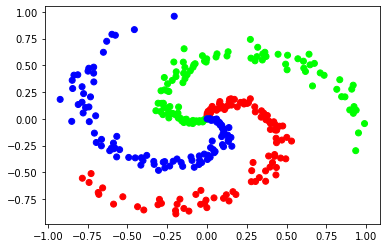

In [100]:
# create the dataset and plot the graph

x, t = load_data()
print("x: {}".format(x.shape))
print("t: {}".format(t.shape))

plt.scatter(x[:,0], x[:,1], color=t)
plt.show()

## 1.2 Custom dataset, split and Dataloader 

In [101]:
# create a custom dataset for the data loader


class spiralDataset(torch.utils.data.Dataset):
    """ Spiral classification dataset"""
    
    def __init__(self, x, t):
        self.x = x
        self.t = t
        
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        x = self.x[index,:]
        t = self.t[index,:].argmax()
        return x, t

    def __len__(self):
        return len(x)
        


In [102]:
# Create dataset and print the first output

x_tensor = torch.Tensor(x)
t_tensor = torch.Tensor(t)
dataset_spiral = spiralDataset(x_tensor,t_tensor)
print(dataset_spiral[0])

(tensor([-0., 0.]), tensor(0))


For this example, we will use a 80%-20% split for the train and validation set

At the end, we will regenerate another 300 sample for the test set

In [103]:
# split dataset

torch.manual_seed(0)

train_data, valid_data = torch.utils.data.random_split(dataset_spiral, [240, 60])

print('Number of training example: {}'.format(len(train_data)))
print('Number of validation example: {}'.format(len(valid_data)))

Number of training example: 240
Number of validation example: 60


In [104]:
# check the distrubution in the data
def checkclass(dataset):
    dic = {0: 0,
           1: 0,
           2: 0}
    for i in range(len(dataset)):
        _,cls_num = dataset[i]
        if cls_num == 0:
            dic[0] += 1
        if cls_num == 1:
            dic[1] += 1
        if cls_num == 2:
            dic[2] += 1
    return dic

print('Train dataset distribution:')
print(checkclass(train_data))
print('Validation dataset distribution:')
print(checkclass(valid_data))

Train dataset distribution:
{0: 79, 1: 80, 2: 81}
Validation dataset distribution:
{0: 21, 1: 20, 2: 19}


From the result, we can see that it is quite evenly distributed

In [105]:
# DataLoader
batch_size = 30

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size, 
                                           shuffle=True)

## 1.3 Model sturcture

In [106]:
class TwoLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        
        # Default Pytorch layer is initialized with a normal distribution
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        # nn.init.xavier_normal_(self.hidden_layer.weight)  
        # Xavier Initialization: UNIFORM between +- sqrt(6 / (n_input + n_output))
        nn.init.kaiming_normal_(self.hidden_layer.weight) # He Initialization: NORMAL with std sqrt(2/n_input)
        
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.batchnorm = nn.BatchNorm1d(num_features=hidden_dim)
        
        
    def forward(self, inputs):
        out = self.hidden_layer(inputs)
        out = self.batchnorm(out)
        out = self.sigmoid(out)
        out = self.dropout(out)
            
        out = self.output_layer(out)

        return out

In [107]:
hidden_dim = 10
output_dim = 3
input_dim = 2
lr = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = TwoLayerNN(input_dim, hidden_dim, output_dim).to(device)

n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("The model has {} parameters".format(n_params))

optimizer = optim.SGD(model.parameters(), lr)

The model has 83 parameters


## 1.4 Training

In [108]:
def eval_accuracy(mode, loader, model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for x, t in loader:
            x = x.reshape(-1,2).to(device)
            t = t.to(device)
            outputs = model(x)
            _, pred = torch.max(outputs.data, 1)
            total += t.size(0)
            correct += (pred == t).sum().item()
            
    acc = 100 * correct / total
    print('Accuracy of the network on {} set: {:.4f} %'.format(mode, acc))
    model.train()
    
    return acc

In [109]:
# Train the model
num_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
total_step = len(train_loader)
eval_accuracy("train", train_loader, model)
eval_accuracy("valid", valid_loader, model)
valid_accs = []
loss_list = []


for epoch in range(num_epochs):
    total_loss = 0
    loss_count = 0
    print('\nNew epoch, epoch {} / {}'.format(epoch+1, num_epochs))
    for i, (x, t) in enumerate(train_loader):
        # Move tensors to the configured device
        x = x.to(device)
        t = t.to(device)
      
        # Forward pass
        outputs = model(x)
        loss = criterion(outputs, t)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5) # Gradient clipping
        optimizer.step()
        
        
        # # Weight Clipping
        #for p in model.parameters():
        #    p.data.clamp_(-0.01, 0.01)
        
        total_loss += loss
        loss_count += 1
        
        if (i+1) % 1 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                 .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    eval_accuracy("train", train_loader, model)
    valid_acc = eval_accuracy("valid", valid_loader, model)
    valid_accs.append(valid_acc)
    avgloss = total_loss / loss_count
    loss_list.append(avgloss)
    
    print("Best validation accuracy so far: {:.4f}, at epoch {}".format(np.max(np.array(valid_accs)), np.argmax(np.array(valid_accs))+1))

Accuracy of the network on train set: 33.3333 %
Accuracy of the network on valid set: 33.3333 %

New epoch, epoch 1 / 200
Epoch [1/200], Step [1/8], Loss: 1.1487
Epoch [1/200], Step [2/8], Loss: 1.1147
Epoch [1/200], Step [3/8], Loss: 1.1010
Epoch [1/200], Step [4/8], Loss: 1.1409
Epoch [1/200], Step [5/8], Loss: 0.9614
Epoch [1/200], Step [6/8], Loss: 1.0681
Epoch [1/200], Step [7/8], Loss: 0.9860
Epoch [1/200], Step [8/8], Loss: 0.9538
Accuracy of the network on train set: 58.3333 %
Accuracy of the network on valid set: 65.0000 %
Best validation accuracy so far: 65.0000, at epoch 1

New epoch, epoch 2 / 200
Epoch [2/200], Step [1/8], Loss: 1.0383
Epoch [2/200], Step [2/8], Loss: 1.1199
Epoch [2/200], Step [3/8], Loss: 1.1514
Epoch [2/200], Step [4/8], Loss: 0.9817
Epoch [2/200], Step [5/8], Loss: 0.9207
Epoch [2/200], Step [6/8], Loss: 0.9915
Epoch [2/200], Step [7/8], Loss: 0.8737
Epoch [2/200], Step [8/8], Loss: 0.9373
Accuracy of the network on train set: 58.7500 %
Accuracy of the

Accuracy of the network on valid set: 61.6667 %
Best validation accuracy so far: 66.6667, at epoch 18

New epoch, epoch 20 / 200
Epoch [20/200], Step [1/8], Loss: 1.0208
Epoch [20/200], Step [2/8], Loss: 0.8757
Epoch [20/200], Step [3/8], Loss: 0.7890
Epoch [20/200], Step [4/8], Loss: 0.7060
Epoch [20/200], Step [5/8], Loss: 0.8511
Epoch [20/200], Step [6/8], Loss: 0.7623
Epoch [20/200], Step [7/8], Loss: 0.8708
Epoch [20/200], Step [8/8], Loss: 0.9273
Accuracy of the network on train set: 63.3333 %
Accuracy of the network on valid set: 65.0000 %
Best validation accuracy so far: 66.6667, at epoch 18

New epoch, epoch 21 / 200
Epoch [21/200], Step [1/8], Loss: 0.8116
Epoch [21/200], Step [2/8], Loss: 0.9863
Epoch [21/200], Step [3/8], Loss: 0.6695
Epoch [21/200], Step [4/8], Loss: 0.9165
Epoch [21/200], Step [5/8], Loss: 0.8888
Epoch [21/200], Step [6/8], Loss: 0.6401
Epoch [21/200], Step [7/8], Loss: 0.8150
Epoch [21/200], Step [8/8], Loss: 0.7319
Accuracy of the network on train set: 

Epoch [39/200], Step [3/8], Loss: 0.8186
Epoch [39/200], Step [4/8], Loss: 0.7950
Epoch [39/200], Step [5/8], Loss: 0.8333
Epoch [39/200], Step [6/8], Loss: 0.8469
Epoch [39/200], Step [7/8], Loss: 0.9698
Epoch [39/200], Step [8/8], Loss: 0.9083
Accuracy of the network on train set: 58.7500 %
Accuracy of the network on valid set: 66.6667 %
Best validation accuracy so far: 70.0000, at epoch 31

New epoch, epoch 40 / 200
Epoch [40/200], Step [1/8], Loss: 0.8033
Epoch [40/200], Step [2/8], Loss: 0.8219
Epoch [40/200], Step [3/8], Loss: 0.6746
Epoch [40/200], Step [4/8], Loss: 0.6345
Epoch [40/200], Step [5/8], Loss: 0.8351
Epoch [40/200], Step [6/8], Loss: 0.9217
Epoch [40/200], Step [7/8], Loss: 0.7228
Epoch [40/200], Step [8/8], Loss: 0.8756
Accuracy of the network on train set: 60.0000 %
Accuracy of the network on valid set: 65.0000 %
Best validation accuracy so far: 70.0000, at epoch 31

New epoch, epoch 41 / 200
Epoch [41/200], Step [1/8], Loss: 0.7253
Epoch [41/200], Step [2/8], Los

Epoch [58/200], Step [8/8], Loss: 0.7127
Accuracy of the network on train set: 70.0000 %
Accuracy of the network on valid set: 76.6667 %
Best validation accuracy so far: 76.6667, at epoch 58

New epoch, epoch 59 / 200
Epoch [59/200], Step [1/8], Loss: 0.8562
Epoch [59/200], Step [2/8], Loss: 0.7509
Epoch [59/200], Step [3/8], Loss: 0.7160
Epoch [59/200], Step [4/8], Loss: 0.5644
Epoch [59/200], Step [5/8], Loss: 0.7521
Epoch [59/200], Step [6/8], Loss: 0.8311
Epoch [59/200], Step [7/8], Loss: 0.6803
Epoch [59/200], Step [8/8], Loss: 0.7348
Accuracy of the network on train set: 70.4167 %
Accuracy of the network on valid set: 75.0000 %
Best validation accuracy so far: 76.6667, at epoch 58

New epoch, epoch 60 / 200
Epoch [60/200], Step [1/8], Loss: 0.7407
Epoch [60/200], Step [2/8], Loss: 0.8133
Epoch [60/200], Step [3/8], Loss: 0.7832
Epoch [60/200], Step [4/8], Loss: 0.8978
Epoch [60/200], Step [5/8], Loss: 0.6233
Epoch [60/200], Step [6/8], Loss: 0.7969
Epoch [60/200], Step [7/8], Los

Epoch [78/200], Step [1/8], Loss: 0.8030
Epoch [78/200], Step [2/8], Loss: 0.4661
Epoch [78/200], Step [3/8], Loss: 0.8145
Epoch [78/200], Step [4/8], Loss: 0.5675
Epoch [78/200], Step [5/8], Loss: 0.7544
Epoch [78/200], Step [6/8], Loss: 0.6895
Epoch [78/200], Step [7/8], Loss: 0.6344
Epoch [78/200], Step [8/8], Loss: 0.5487
Accuracy of the network on train set: 77.5000 %
Accuracy of the network on valid set: 81.6667 %
Best validation accuracy so far: 81.6667, at epoch 77

New epoch, epoch 79 / 200
Epoch [79/200], Step [1/8], Loss: 0.6839
Epoch [79/200], Step [2/8], Loss: 0.7247
Epoch [79/200], Step [3/8], Loss: 0.4659
Epoch [79/200], Step [4/8], Loss: 0.6754
Epoch [79/200], Step [5/8], Loss: 0.9017
Epoch [79/200], Step [6/8], Loss: 0.6551
Epoch [79/200], Step [7/8], Loss: 0.5281
Epoch [79/200], Step [8/8], Loss: 0.6407
Accuracy of the network on train set: 84.5833 %
Accuracy of the network on valid set: 81.6667 %
Best validation accuracy so far: 81.6667, at epoch 77

New epoch, epoch

Epoch [97/200], Step [7/8], Loss: 0.6523
Epoch [97/200], Step [8/8], Loss: 0.5815
Accuracy of the network on train set: 89.1667 %
Accuracy of the network on valid set: 85.0000 %
Best validation accuracy so far: 86.6667, at epoch 81

New epoch, epoch 98 / 200
Epoch [98/200], Step [1/8], Loss: 0.5285
Epoch [98/200], Step [2/8], Loss: 0.5617
Epoch [98/200], Step [3/8], Loss: 0.7291
Epoch [98/200], Step [4/8], Loss: 0.7923
Epoch [98/200], Step [5/8], Loss: 0.5207
Epoch [98/200], Step [6/8], Loss: 0.7298
Epoch [98/200], Step [7/8], Loss: 0.5237
Epoch [98/200], Step [8/8], Loss: 0.6867
Accuracy of the network on train set: 87.0833 %
Accuracy of the network on valid set: 85.0000 %
Best validation accuracy so far: 86.6667, at epoch 81

New epoch, epoch 99 / 200
Epoch [99/200], Step [1/8], Loss: 0.6025
Epoch [99/200], Step [2/8], Loss: 0.6005
Epoch [99/200], Step [3/8], Loss: 0.5328
Epoch [99/200], Step [4/8], Loss: 0.7025
Epoch [99/200], Step [5/8], Loss: 0.7548
Epoch [99/200], Step [6/8], Los

Epoch [116/200], Step [5/8], Loss: 0.6060
Epoch [116/200], Step [6/8], Loss: 0.6986
Epoch [116/200], Step [7/8], Loss: 0.9562
Epoch [116/200], Step [8/8], Loss: 0.6314
Accuracy of the network on train set: 85.4167 %
Accuracy of the network on valid set: 86.6667 %
Best validation accuracy so far: 88.3333, at epoch 108

New epoch, epoch 117 / 200
Epoch [117/200], Step [1/8], Loss: 0.5235
Epoch [117/200], Step [2/8], Loss: 0.4288
Epoch [117/200], Step [3/8], Loss: 0.6634
Epoch [117/200], Step [4/8], Loss: 0.4724
Epoch [117/200], Step [5/8], Loss: 0.4412
Epoch [117/200], Step [6/8], Loss: 0.5532
Epoch [117/200], Step [7/8], Loss: 0.4859
Epoch [117/200], Step [8/8], Loss: 0.4540
Accuracy of the network on train set: 90.8333 %
Accuracy of the network on valid set: 86.6667 %
Best validation accuracy so far: 88.3333, at epoch 108

New epoch, epoch 118 / 200
Epoch [118/200], Step [1/8], Loss: 0.3955
Epoch [118/200], Step [2/8], Loss: 0.4537
Epoch [118/200], Step [3/8], Loss: 0.4554
Epoch [118/2

Accuracy of the network on valid set: 85.0000 %
Best validation accuracy so far: 90.0000, at epoch 130

New epoch, epoch 136 / 200
Epoch [136/200], Step [1/8], Loss: 0.7285
Epoch [136/200], Step [2/8], Loss: 0.5978
Epoch [136/200], Step [3/8], Loss: 0.3910
Epoch [136/200], Step [4/8], Loss: 0.6680
Epoch [136/200], Step [5/8], Loss: 0.4973
Epoch [136/200], Step [6/8], Loss: 0.3010
Epoch [136/200], Step [7/8], Loss: 0.6690
Epoch [136/200], Step [8/8], Loss: 0.4250
Accuracy of the network on train set: 87.9167 %
Accuracy of the network on valid set: 86.6667 %
Best validation accuracy so far: 90.0000, at epoch 130

New epoch, epoch 137 / 200
Epoch [137/200], Step [1/8], Loss: 0.6565
Epoch [137/200], Step [2/8], Loss: 0.4428
Epoch [137/200], Step [3/8], Loss: 0.5835
Epoch [137/200], Step [4/8], Loss: 0.5629
Epoch [137/200], Step [5/8], Loss: 0.5432
Epoch [137/200], Step [6/8], Loss: 0.4108
Epoch [137/200], Step [7/8], Loss: 0.5978
Epoch [137/200], Step [8/8], Loss: 0.5103
Accuracy of the ne

Epoch [155/200], Step [4/8], Loss: 0.3376
Epoch [155/200], Step [5/8], Loss: 0.6244
Epoch [155/200], Step [6/8], Loss: 0.6891
Epoch [155/200], Step [7/8], Loss: 0.4609
Epoch [155/200], Step [8/8], Loss: 0.4753
Accuracy of the network on train set: 92.5000 %
Accuracy of the network on valid set: 88.3333 %
Best validation accuracy so far: 91.6667, at epoch 150

New epoch, epoch 156 / 200
Epoch [156/200], Step [1/8], Loss: 0.5350
Epoch [156/200], Step [2/8], Loss: 0.5995
Epoch [156/200], Step [3/8], Loss: 0.4363
Epoch [156/200], Step [4/8], Loss: 0.5901
Epoch [156/200], Step [5/8], Loss: 0.5070
Epoch [156/200], Step [6/8], Loss: 0.5613
Epoch [156/200], Step [7/8], Loss: 0.4182
Epoch [156/200], Step [8/8], Loss: 0.5639
Accuracy of the network on train set: 90.8333 %
Accuracy of the network on valid set: 86.6667 %
Best validation accuracy so far: 91.6667, at epoch 150

New epoch, epoch 157 / 200
Epoch [157/200], Step [1/8], Loss: 0.6032
Epoch [157/200], Step [2/8], Loss: 0.5078
Epoch [157/2

Epoch [174/200], Step [3/8], Loss: 0.5720
Epoch [174/200], Step [4/8], Loss: 0.6226
Epoch [174/200], Step [5/8], Loss: 0.4156
Epoch [174/200], Step [6/8], Loss: 0.8076
Epoch [174/200], Step [7/8], Loss: 0.5637
Epoch [174/200], Step [8/8], Loss: 0.3952
Accuracy of the network on train set: 93.7500 %
Accuracy of the network on valid set: 88.3333 %
Best validation accuracy so far: 91.6667, at epoch 150

New epoch, epoch 175 / 200
Epoch [175/200], Step [1/8], Loss: 0.4605
Epoch [175/200], Step [2/8], Loss: 0.6497
Epoch [175/200], Step [3/8], Loss: 0.3913
Epoch [175/200], Step [4/8], Loss: 0.4392
Epoch [175/200], Step [5/8], Loss: 0.6629
Epoch [175/200], Step [6/8], Loss: 1.0930
Epoch [175/200], Step [7/8], Loss: 0.6140
Epoch [175/200], Step [8/8], Loss: 0.4068
Accuracy of the network on train set: 92.0833 %
Accuracy of the network on valid set: 91.6667 %
Best validation accuracy so far: 91.6667, at epoch 150

New epoch, epoch 176 / 200
Epoch [176/200], Step [1/8], Loss: 0.4421
Epoch [176/2

Accuracy of the network on train set: 92.0833 %
Accuracy of the network on valid set: 90.0000 %
Best validation accuracy so far: 91.6667, at epoch 150

New epoch, epoch 193 / 200
Epoch [193/200], Step [1/8], Loss: 0.5887
Epoch [193/200], Step [2/8], Loss: 0.5084
Epoch [193/200], Step [3/8], Loss: 0.3956
Epoch [193/200], Step [4/8], Loss: 0.3245
Epoch [193/200], Step [5/8], Loss: 0.6673
Epoch [193/200], Step [6/8], Loss: 0.7504
Epoch [193/200], Step [7/8], Loss: 0.5415
Epoch [193/200], Step [8/8], Loss: 0.4017
Accuracy of the network on train set: 92.0833 %
Accuracy of the network on valid set: 90.0000 %
Best validation accuracy so far: 91.6667, at epoch 150

New epoch, epoch 194 / 200
Epoch [194/200], Step [1/8], Loss: 0.5535
Epoch [194/200], Step [2/8], Loss: 0.4986
Epoch [194/200], Step [3/8], Loss: 0.5630
Epoch [194/200], Step [4/8], Loss: 0.3311
Epoch [194/200], Step [5/8], Loss: 0.5648
Epoch [194/200], Step [6/8], Loss: 0.3881
Epoch [194/200], Step [7/8], Loss: 0.4981
Epoch [194/2

## 1.5 Plot loss

Text(0, 0.5, 'Loss')

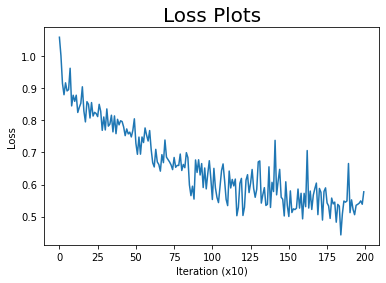

In [110]:
# Plot Loss ----------------------------
fig, axes = plt.subplots(1,1)
axes.plot(np.arange(len(loss_list)), loss_list, label='train')
axes.set_title('Loss Plots', fontsize=20)
axes.set_xlabel('Iteration (x10)')
axes.set_ylabel('Loss')

Batch Norm casues the gradient to explode. For this example, there is no large gradient spike. Gradient clip maybe not have good effects of our model.

## 1.6 Generate a test set and plot the test result

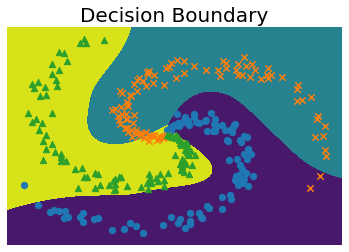

In [111]:
# Decision Boundary 
x, t = load_data(0) # Test dataset

h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
X = torch.Tensor(X)

with torch.no_grad():
  model.eval() # turn off dropout and batch_norm
  score = model.forward(X)
predict_cls = np.argmax(score.data.numpy(), axis=1)
Z = predict_cls.reshape(xx.shape)
fig, axes = plt.subplots(1,1)
axes.set_title('Decision Boundary', fontsize=20)
axes.contourf(xx, yy, Z)
axes.axis('off')

# Plot Data 
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    axes.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

# Thanks for reading!